Config(N=50000, alpha=2.1, kmin=1, kmax=None, k_avg_hint=8.0, r_targets=(-0.35, -0.25, -0.15, -0.05), rho_grid=(np.float64(0.0), np.float64(0.05), np.float64(0.1), np.float64(0.15), np.float64(0.2), np.float64(0.25), np.float64(0.3), np.float64(0.35), np.float64(0.4), np.float64(0.45), np.float64(0.5), np.float64(0.55)), tol_r=0.005, max_rewire_steps_per_edge=5.0, tol_rho=0.015, max_bias_bisection=20, p_global=0.1, sample_nodes=None, trials_per_rho=1, rng_seed=42)


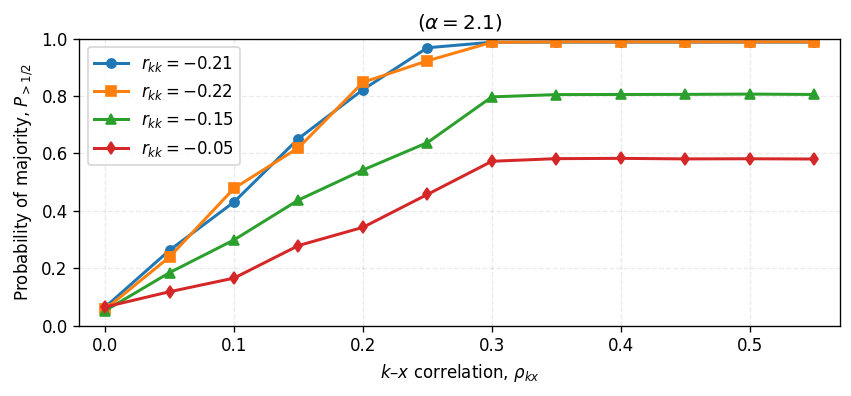

In [4]:
# scale-free-fig2-fixed.py
# Majority Illusion — Fig. 2 (α panel) — rápido y fiel

import numpy as np
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Tuple, List

# -------------------- PRESET --------------------
@dataclass
class Config:
    N: int = 50000
    alpha: float = 2.1
    kmin: int = 1
    kmax: int | None = None      # si None, usa truncamiento suave
    k_avg_hint: float = 8.0
#    r_targets: Tuple[float,...] = (-0.35, -0.25, -0.15, -0.05)
    r_targets: Tuple[float,...] = (-0.35, -0.25, -0.15, -0.05)
    rho_grid: Tuple[float,...] = tuple(np.round(np.linspace(0.0, 0.55, 12), 2))
    tol_r: float = 0.005
    max_rewire_steps_per_edge: float = 5.0
    tol_rho: float = 0.015
    max_bias_bisection: int = 20
    p_global: float = 0.10        # prevalencia global del atributo
    sample_nodes: int | None = None  # muestreo opcional en la GCC
    trials_per_rho: int = 1
    rng_seed: int = 42

CFG = Config()

# -------------------- RED POWER-LAW --------------------
def sample_powerlaw_degrees(N:int, alpha:float, kmin:int=1, kmax:int|None=None, rng=None):
    """Secuencia de grados con p(k) ~ k^{-alpha} truncada en [kmin, kmax]."""
    if rng is None: rng = np.random.default_rng()
    if kmax is None:
        # truncamiento suave para evitar súper-hubs muy pesados
        kmax = int(max(kmin, min(N-1, (N**0.5)*10)))
    kmax = int(min(kmax, N-1))
    ks = np.arange(kmin, kmax+1, dtype=int)
    pk = ks.astype(float)**(-alpha); pk /= pk.sum()
    deg = rng.choice(ks, size=N, replace=True, p=pk)
    if deg.sum() % 2 == 1:
        i = rng.integers(0, N); deg[i] = min(deg[i]+1, kmax)
    deg = np.maximum(deg, kmin)
    return deg

def config_graph_from_seq(deg: np.ndarray, seed: int = 42) -> nx.Graph:
    Gm = nx.configuration_model(deg, seed=seed)
    G = nx.Graph(Gm)              # simple
    G.remove_edges_from(nx.selfloop_edges(G))
    return G

# -------------------- REWIRING A r_kk --------------------
def _assort_constants_from_degrees(G: nx.Graph, deg: Dict[int,int] = None):
    if deg is None: deg = dict(G.degree())
    M = G.number_of_edges()
    deg_arr = np.array(list(deg.values()), dtype=float)
    B = 0.5 * np.sum(deg_arr**2)      # constante
    C = 0.5 * np.sum(deg_arr**3)      # constante
    A = 0
    for u, v in G.edges():
        A += deg[u]*deg[v]            # solo A cambia con swaps
    denom = (C/M - (B/M)**2)
    return A, B, C, M, denom, deg

def assort_from_A(A: float, B: float, C: float, M: float) -> float:
    return (A/M - (B/M)**2) / (C/M - (B/M)**2)

def rewire_to_rkk(G: nx.Graph, r_target: float, tol: float = 0.01,
                  max_rewire_steps_per_edge: float = 3.0, seed: int = 42,
                  verbose: bool = False) -> float:
    """
    Rewire degree-preserving hacia r_target via edge swaps, evitando multi-edges.
    Optimiza A = Σ_e k_i k_j, que controla r con el resto fijo.
    """
    rng = np.random.default_rng(seed)
    A, B, C, M, denom, deg = _assort_constants_from_degrees(G)
    if denom <= 0:
        return nx.degree_assortativity_coefficient(G)

    r = assort_from_A(A, B, C, M)
    edges: List[Tuple[int,int]] = list(G.edges())
    adj = {u: set(G.neighbors(u)) for u in G.nodes()}

    steps = int(max_rewire_steps_per_edge * M)
    direction = 1 if r_target > r else -1    # +1 sube r, -1 baja r
    no_improve = 0
    for t in range(steps):
        i = rng.integers(len(edges)); j = rng.integers(len(edges))
        if i == j: 
            continue
        a, b = edges[i]; c, d = edges[j]
        if len({a,b,c,d}) < 4:
            continue

        valid1 = (c not in adj[a]) and (d not in adj[b]) and (a != c) and (b != d)
        valid2 = (d not in adj[a]) and (c not in adj[b]) and (a != d) and (b != c)
        if not (valid1 or valid2):
            continue

        ka, kb, kc, kd = deg[a], deg[b], deg[c], deg[d]
        current = ka*kb + kc*kd
        delta1 = (ka*kc + kb*kd) - current   # (a,c),(b,d)
        delta2 = (ka*kd + kb*kc) - current   # (a,d),(b,c)

        if direction > 0:
            # queremos aumentar A
            cand = []
            if valid1: cand.append(("ac_bd", delta1))
            if valid2: cand.append(("ad_bc", delta2))
            if not cand: 
                continue
            label, delta = max(cand, key=lambda x: x[1])
        else:
            # queremos disminuir A
            cand = []
            if valid1: cand.append(("ac_bd", delta1))
            if valid2: cand.append(("ad_bc", delta2))
            if not cand:
                continue
            label, delta = min(cand, key=lambda x: x[1])

        # early rejection si no mejora
        if (direction > 0 and delta <= 0) or (direction < 0 and delta >= 0):
            no_improve += 1
            if no_improve > 5000:
                r = assort_from_A(A, B, C, M)
                direction = 1 if r_target > r else -1
                no_improve = 0
            continue

        # aplica swap manteniendo simpleza
        G.remove_edge(a, b); adj[a].remove(b); adj[b].remove(a)
        G.remove_edge(c, d); adj[c].remove(d); adj[d].remove(c)
        if label == "ac_bd":
            G.add_edge(a, c); adj[a].add(c); adj[c].add(a)
            G.add_edge(b, d); adj[b].add(d); adj[d].add(b)
            edges[i] = (a, c); edges[j] = (b, d)
        else:
            G.add_edge(a, d); adj[a].add(d); adj[d].add(a)
            G.add_edge(b, c); adj[b].add(c); adj[c].add(b)
            edges[i] = (a, d); edges[j] = (b, c)

        A += delta
        r = assort_from_A(A, B, C, M)
        direction = 1 if r_target > r else -1
        if verbose and (t % (M//2 + 1) == 0):
            print(f"[{t}/{steps}] r≈{r:.4f} (target {r_target:+.2f})")
        if abs(r - r_target) <= tol:
            break

    return r

# -------------------- ATRIBUTO: rho objetivo y p fijo --------------------
def assign_attribute_with_rho_and_p(k: np.ndarray, rho_target: float, p: float,
                                    tol: float = 0.015, max_iter: int = 20,
                                    rng=None):
    """
    x ∈ {0,1}^N con prevalencia global p y correlación con k cercana a rho_target.
    Estrategia: bisección sobre beta en probabilidades ∝ k^beta.
    """
    if rng is None: rng = np.random.default_rng()
    N = len(k); m = int(round(p * N))
    lo, hi = -8.0, +8.0
    x_best, rho_best = None, -1.0
    for _ in range(max_iter):
        beta = 0.5*(lo + hi)
        w = k.astype(float)**beta
        w = np.nan_to_num(w, nan=0.0, posinf=0.0, neginf=0.0)
        if w.sum() == 0:
            w = np.ones_like(w)
        w = w / w.sum()
        idx = rng.choice(N, size=m, replace=False, p=w)
        x = np.zeros(N, dtype=np.int8); x[idx] = 1
        rho = np.corrcoef(k, x)[0,1]
        x_best, rho_best = x, rho
        if abs(rho - rho_target) <= tol:
            break
        if rho < rho_target:
            lo = beta
        else:
            hi = beta
    return x_best, rho_best

# -------------------- MÉTRICA P>1/2 EN LA GCC --------------------
def prob_majority_in_gcc(G: nx.Graph, x: np.ndarray, sample_nodes: int | None = None) -> float:
    GCC = max(nx.connected_components(G), key=len)
    H = G.subgraph(GCC).copy()
    nodes = np.array(list(H.nodes()), dtype=int)
    xH = x[nodes]
    A = nx.to_scipy_sparse_array(H, format="csr", dtype=np.int8)
    deg = np.asarray(A.sum(1)).ravel()
    ok = deg > 0
    if sample_nodes is not None and sample_nodes < ok.sum():
        rng = np.random.default_rng(123)
        idx = np.where(ok)[0]
        choose = rng.choice(idx, size=sample_nodes, replace=False)
        mask = np.zeros_like(ok, dtype=bool); mask[choose] = True
        ok = mask
    counts = (A @ xH)
    return (counts[ok] > 0.5*deg[ok]).mean()

# -------------------- PIPELINE PANEL --------------------
def run_panel(alpha: float, cfg: Config = CFG):
    rng = np.random.default_rng(cfg.rng_seed)
    results = {}; r_measured = {}
    for r_target in cfg.r_targets:
        deg = sample_powerlaw_degrees(cfg.N, alpha, cfg.kmin, cfg.kmax, rng)
        G = config_graph_from_seq(deg, seed=cfg.rng_seed)
        r_real = rewire_to_rkk(G, r_target, tol=cfg.tol_r,
                               max_rewire_steps_per_edge=cfg.max_rewire_steps_per_edge,
                               seed=cfg.rng_seed, verbose=False)
        r_measured[r_target] = r_real
        k = np.array([d for _, d in sorted(G.degree(), key=lambda x: x[0])], dtype=int)

        vals = []
        for rho_target in cfg.rho_grid:
            acc = []
            for _ in range(cfg.trials_per_rho):
                x, rho_real = assign_attribute_with_rho_and_p(k, rho_target, cfg.p_global,
                                                              tol=cfg.tol_rho,
                                                              max_iter=cfg.max_bias_bisection,
                                                              rng=rng)
                p = prob_majority_in_gcc(G, x, sample_nodes=cfg.sample_nodes)
                acc.append(p)
            vals.append(float(np.mean(acc)))
        results[r_target] = vals

    return results, r_measured

def plot_panel(alpha: float, results, r_measured, cfg: Config = CFG):
    plt.figure(figsize=(7.2, 3.4), dpi=120)
    markers = ["o", "s", "^", "d", "x", "v"]
    for i, r_target in enumerate(cfg.r_targets):
        lab = rf"$r_{{kk}}={r_measured[r_target]:+.2f}$"
        plt.plot(cfg.rho_grid, results[r_target], marker=markers[i%len(markers)],
                 linewidth=1.8, markersize=5.5, label=lab)
    plt.ylim(0, 1.0)
    plt.xlim(min(cfg.rho_grid)-0.02, max(cfg.rho_grid)+0.02)
    plt.xlabel(r"$k\text{–}x$ correlation, $\rho_{kx}$")
    plt.ylabel(r"Probability of majority, $P_{>1/2}$")
    plt.title(rf"($\alpha = {alpha}$)")
    plt.legend(frameon=True)
    plt.grid(True, alpha=0.25, linestyle="--")
    plt.tight_layout()
    plt.show()

# -------------------- EJECUCIÓN --------------------
if __name__ == "__main__":
    print(CFG)
    res, r_meas = run_panel(CFG.alpha, CFG)
    plot_panel(CFG.alpha, res, r_meas, CFG)
